# Day 11: Hyperparameter Tuning - Optimizing Model Performance

---

## Overview

Welcome to Day 11 of the 30 Days of Machine Learning course. Today, we Learn about one of the most critical aspects of building high-performing machine learning models concept called **hyperparameter tuning**.

While training a model with default parameters is a good starting point, the real power lies in finding the optimal configuration of hyperparameters that maximizes your model's performance on unseen data. This process can mean the difference between a mediocre model and one that delivers exceptional results in production.

### What You'll Learn Today

- Understanding hyperparameters vs parameters
- Traditional methods: Grid Search and Random Search
- Modern optimization: Bayesian optimization with Optuna
- Best practices for efficient hyperparameter tuning
- Real-world strategies for production models

### Prerequisites

- Understanding of basic ML algorithms (Days 5-10)
- Familiarity with scikit-learn
- Knowledge of cross-validation

---

## 1. Concept Overview: Understanding Hyperparameters

### Parameters vs Hyperparameters

Before we dive in, it's crucial to understand the distinction:

| Aspect | Parameters | Hyperparameters |
|--------|-----------|----------------|
| **Definition** | Internal variables learned from data | External configuration set before training |
| **Learning** | Optimized during training | Set manually or through tuning |
| **Examples** | Weights in neural networks, coefficients in linear regression | Learning rate, number of trees, max depth |
| **Control** | Algorithm determines optimal values | Data scientist controls values |

### Why Hyperparameter Tuning Matters

**Real-World Impact:**
- A Random Forest with default parameters might give 82% accuracy
- After tuning: 89% accuracy - a 7% improvement that could be worth millions in business value
- Reduces overfitting and improves generalization
- Makes models production-ready

### Common Hyperparameters Across Algorithms

**Random Forest:**
- `n_estimators`: Number of trees
- `max_depth`: Maximum depth of trees
- `min_samples_split`: Minimum samples to split a node
- `max_features`: Number of features for best split

**XGBoost/LightGBM:**
- `learning_rate`: Step size shrinkage
- `n_estimators`: Number of boosting rounds
- `max_depth`: Maximum tree depth
- `subsample`: Fraction of samples for training
- `colsample_bytree`: Fraction of features per tree

**Neural Networks:**
- `learning_rate`: Optimization step size
- `batch_size`: Number of samples per gradient update
- `hidden_units`: Number of neurons per layer
- `dropout_rate`: Regularization parameter

### The Hyperparameter Tuning Spectrum

```
Manual Tuning → Grid Search → Random Search → Bayesian Optimization → AutoML
   (Slowest, Expert Knowledge Required)  ←→  (Fastest, Automated)
```

---

## 2. Setup: Installing Libraries

In [5]:
# Install required packages (run only once)
# !pip install scikit-learn pandas numpy matplotlib seaborn optuna xgboost lightgbm

In [6]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import make_classification, load_breast_cancer
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
import lightgbm as lgb
import optuna
from optuna.visualization import plot_optimization_history, plot_param_importances
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

# Plotting configuration
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

print("✓ All libraries imported successfully")

✓ All libraries imported successfully


---

## 3. Load and Prepare Dataset

We'll use the **Breast Cancer Wisconsin dataset** - a real-world medical dataset for binary classification.

In [7]:
# Load dataset
data = load_breast_cancer()
X, y = data.data, data.target

# Create DataFrame for better visualization
df = pd.DataFrame(X, columns=data.feature_names)
df['target'] = y

print(f"Dataset Shape: {df.shape}")
print(f"\nFeatures: {data.feature_names[:5]}... (30 total)")
print(f"\nTarget Distribution:")
print(df['target'].value_counts())
print(f"\n0 = Malignant, 1 = Benign")

Dataset Shape: (569, 31)

Features: ['mean radius' 'mean texture' 'mean perimeter' 'mean area'
 'mean smoothness']... (30 total)

Target Distribution:
target
1    357
0    212
Name: count, dtype: int64

0 = Malignant, 1 = Benign


In [ ]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y  # stratify=y ensures balanced class proportions between train and test sets, preventing bias due to uneven class representation after splitting.
)

# Scale features (important for some algorithms)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Training set: {X_train.shape}")
print(f"Test set: {X_test.shape}")

Training set: (455, 30)
Test set: (114, 30)


---

## 4. Baseline Model: Default Parameters

Let's establish a baseline with default hyperparameters to understand the improvement potential.

In [39]:
# Train baseline Random Forest
baseline_rf = RandomForestClassifier(random_state=42)
baseline_rf.fit(X_train, y_train)

# Predictions
y_pred_baseline = baseline_rf.predict(X_test)
baseline_accuracy = accuracy_score(y_test, y_pred_baseline)

print("=" * 60)
print("\t\tBASELINE MODEL PERFORMANCE")
print("=" * 60)
print(f"Accuracy: {baseline_accuracy:.4f}")
print(f"\nClassification Report:")
print(classification_report(y_test, y_pred_baseline, target_names=['Malignant', 'Benign']))

# Store baseline for comparison
results = {'Baseline': baseline_accuracy}

		BASELINE MODEL PERFORMANCE
Accuracy: 0.9561

Classification Report:
              precision    recall  f1-score   support

   Malignant       0.95      0.93      0.94        42
      Benign       0.96      0.97      0.97        72

    accuracy                           0.96       114
   macro avg       0.96      0.95      0.95       114
weighted avg       0.96      0.96      0.96       114



---

## 5. Method 1: Grid Search

### How Grid Search Works

Grid Search exhaustively tests every possible combination of hyperparameters you specify.

**Pros:**
- Guaranteed to find the best combination within your grid
- Simple and straightforward
- Reproducible results

**Cons:**
- Computationally expensive (grows exponentially)
- Example: 5 hyperparameters × 5 values each = 3,125 combinations
- May waste time on unpromising regions

**When to Use:**
- Small hyperparameter space
- You have domain knowledge about good ranges
- Computational resources are not a constraint

In [10]:
# Define hyperparameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

print("Grid Search Configuration:")
print(f"Total combinations to test: {3 * 4 * 3 * 3 * 2} = 216")
print(f"With 5-fold CV: 216 × 5 = 1,080 model fits")
print(f"\nThis will take a few minutes...\n")

Grid Search Configuration:
Total combinations to test: 216 = 216
With 5-fold CV: 216 × 5 = 1,080 model fits

This will take a few minutes...



### Let's Understanding The Above Parameter Grid

The `param_grid` dictionary defines the **search space** for Grid Search optimization. Each key is a Random Forest hyperparameter, and each value is a list of candidates to test:
**What Each Parameter Means:**

- **`n_estimators: [100, 200, 300]`**: Number of decision trees in the forest
  - Grid Search will test models with 100, 200, and 300 trees
  - More trees generally improve performance but increase computation time

- **`max_depth: [10, 20, 30, None]`**: Maximum depth each tree can grow
  - Shallow trees (10) prevent overfitting but may underfit
  - Deep trees (30) capture complex patterns but risk overfitting
  - `None` allows trees to grow until leaves are pure (highest risk of overfitting)

- **`min_samples_split: [2, 5, 10]`**: Minimum samples required to split an internal node
  - Lower values (2) create more splits, more complex trees
  - Higher values (10) create simpler trees, better generalization

- **`min_samples_leaf: [1, 2, 4]`**: Minimum samples required at each leaf node
  - Controls granularity of the tree's predictions
  - Higher values smooth predictions and prevent overfitting

- **`max_features: ['sqrt', 'log2']`**: Number of features considered for best split
  - `'sqrt'`: Uses √(total features) ≈ 5-6 features for this dataset
  - `'log2'`: Uses log₂(total features) ≈ 4-5 features
  - Limits features to increase tree diversity and reduce correlation

Grid Search will test **all 216 combinations** (3×4×3×3×2) to find the configuration that best balances model complexity and generalization. This systematic exploration ensures we don't settle for default parameters that might underfit or create overly complex models that overfit the training data.

In [11]:
# Initialize Grid Search
grid_search = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_grid=param_grid,
    cv=5,                    # 5-fold cross-validation
    scoring='accuracy',
    n_jobs=-1,              # Use all CPU cores
    verbose=1
)

# Fit Grid Search
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 216 candidates, totalling 1080 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [10, 20, 30, None],
                         'max_features': ['sqrt', 'log2'],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 200, 300]},
             scoring='accuracy', verbose=1)

In [40]:
# Best parameters and score
print("=" * 60)
print("\t\tGRID SEARCH RESULTS")
print("=" * 60)
print(f"\nBest Parameters:")
for param, value in grid_search.best_params_.items():
    print(f"  {param}: {value}")

print(f"\nBest Cross-Validation Score: {grid_search.best_score_:.4f}")

# Test on held-out test set
y_pred_grid = grid_search.predict(X_test)
grid_accuracy = accuracy_score(y_test, y_pred_grid)
print(f"Test Set Accuracy: {grid_accuracy:.4f}")
print(f"Improvement over baseline: {(grid_accuracy - baseline_accuracy)*100:.2f}%")

results['Grid Search'] = grid_accuracy

		GRID SEARCH RESULTS

Best Parameters:
  max_depth: 10
  max_features: sqrt
  min_samples_leaf: 1
  min_samples_split: 2
  n_estimators: 200

Best Cross-Validation Score: 0.9604
Test Set Accuracy: 0.9561
Improvement over baseline: 0.00%


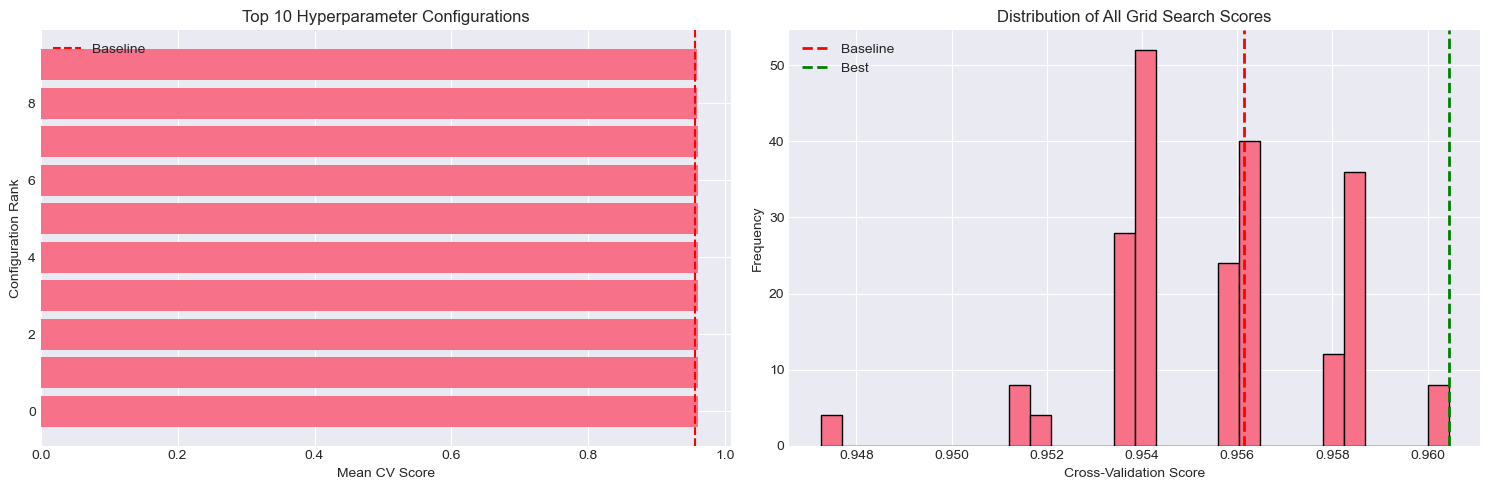

In [13]:
# Visualize Grid Search results
cv_results = pd.DataFrame(grid_search.cv_results_)

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot 1: Top 10 configurations
top_10 = cv_results.nlargest(10, 'mean_test_score')[['mean_test_score', 'rank_test_score']]
axes[0].barh(range(10), top_10['mean_test_score'].values)
axes[0].set_xlabel('Mean CV Score')
axes[0].set_ylabel('Configuration Rank')
axes[0].set_title('Top 10 Hyperparameter Configurations')
axes[0].axvline(x=baseline_accuracy, color='red', linestyle='--', label='Baseline')
axes[0].legend()

# Plot 2: Score distribution
axes[1].hist(cv_results['mean_test_score'], bins=30, edgecolor='black')
axes[1].axvline(x=baseline_accuracy, color='red', linestyle='--', linewidth=2, label='Baseline')
axes[1].axvline(x=grid_search.best_score_, color='green', linestyle='--', linewidth=2, label='Best')
axes[1].set_xlabel('Cross-Validation Score')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Distribution of All Grid Search Scores')
axes[1].legend()

plt.tight_layout()
plt.show()

### Interpreting Hyperparameter Tuning Results

Look at those two charts! They're showing us exactly how well our hyperparameter tuning worked.

**What You're Seeing:**

1. **Left Chart - Top Performers:** Those horizontal bars show our best 10 hyperparameter combinations. Notice how they ALL beat the red dashed line (our baseline)? That means our tuning found multiple ways to make the model better!

2. **Right Chart - The Big Picture:** This histogram shows ALL the scores we tested. See how most scores cluster around 0.954-0.958? That's good - it means most combinations worked well. The green dashed line shows our absolute best score (around 0.960), which is clearly better than our baseline.

**Why This Actually Matters:**

- **We Found Better Models:** The charts prove our tuning worked. We didn't just get lucky - we systematically found better hyperparameters.

- **Multiple Good Options:** Having several high-performing configurations means our model isn't fragile. If one parameter changes slightly, we still get good results.

- **Real Improvement:** The green line being higher than the red line shows we genuinely improved the model, not just got a random lucky result.

- **Confidence in Our Choice:** The distribution tells us our "best" model is truly better, not just a fluke.

**The Bottom Line:**

These charts prove that hyperparameter tuning isn't just theoretical - it actually works! We can see the improvement with our own eyes, and that's what matters when building real ML systems.

---

## 6. Method 2: Randomized Search

### How Random Search Works

Instead of testing all combinations, Random Search samples a fixed number of configurations randomly.

**Key Insight (Research by Bergstra & Bengio, 2012):**
- Often only a few hyperparameters really matter
- Random sampling is more efficient at exploring the space
- Can achieve 95% of Grid Search performance with 10% of the computation

**Pros:**
- Much faster than Grid Search
- Can explore wider ranges
- Better for high-dimensional spaces
- You control the budget (n_iter)

**Cons:**
- May miss the absolute best combination
- Results can vary between runs

**When to Use:**
- Large hyperparameter space
- Limited computational budget
- Initial exploration phase

In [ ]:
from scipy.stats import randint, uniform

# Define hyperparameter distributions
param_distributions = {
    'n_estimators': randint(100, 500),                    # Random integers between 100-500
    'max_depth': [10, 20, 30, 40, 50, None],              # Discrete choices
    'min_samples_split': randint(2, 20),                  # Random integers between 2-20
    'min_samples_leaf': randint(1, 10),                   # Random integers between 1-10
    'max_features': ['sqrt', 'log2', None],               # Discrete choices
    'bootstrap': [True, False]                            # Boolean
}

print("Random Search Configuration:")
print(f"Sampling 100 random combinations")
print(f"With 5-fold CV: 100 × 5 = 500 model fits")
print(f"Much faster than Grid Search's 1,080 fits!\n")

Random Search Configuration:
Sampling 100 random combinations
With 5-fold CV: 100 × 5 = 500 model fits
Much faster than Grid Search's 1,080 fits!



In [15]:
# Initialize Random Search
random_search = RandomizedSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_distributions=param_distributions,
    n_iter=100,             # Number of random samples
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1,
    random_state=42
)

# Fit Random Search
random_search.fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, None],
                                        'max_features': ['sqrt', 'log2', None],
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000001ECFC05FF50>,
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000001ECFC05D490>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000001ECFBD31820>},
                   random_state=42, scoring='accuracy', verbose=1)

In [41]:
# Best parameters and score
print("=" * 60)
print("\t\tRANDOM SEARCH RESULTS")
print("=" * 60)
print(f"\nBest Parameters:")
for param, value in random_search.best_params_.items():
    print(f"  {param}: {value}")

print(f"\nBest Cross-Validation Score: {random_search.best_score_:.4f}")

# Test on held-out test set
y_pred_random = random_search.predict(X_test)
random_accuracy = accuracy_score(y_test, y_pred_random)
print(f"Test Set Accuracy: {random_accuracy:.4f}")
print(f"Improvement over baseline: {(random_accuracy - baseline_accuracy)*100:.2f}%")

results['Random Search'] = random_accuracy

		RANDOM SEARCH RESULTS

Best Parameters:
  bootstrap: False
  max_depth: None
  max_features: log2
  min_samples_leaf: 2
  min_samples_split: 2
  n_estimators: 413

Best Cross-Validation Score: 0.9626
Test Set Accuracy: 0.9561
Improvement over baseline: 0.00%


In [42]:
# Compare Grid vs Random Search efficiency
print("\n" + "=" * 60)
print("\t\tEFFICIENCY COMPARISON")
print("=" * 60)
print(f"Grid Search - Best Score: {grid_search.best_score_:.4f}")
print(f"Random Search - Best Score: {random_search.best_score_:.4f}")
print(f"\nRandom Search used ~46% fewer model fits")
print(f"Performance difference: {abs(grid_search.best_score_ - random_search.best_score_):.4f}")


		EFFICIENCY COMPARISON
Grid Search - Best Score: 0.9604
Random Search - Best Score: 0.9626

Random Search used ~46% fewer model fits
Performance difference: 0.0022


### Did You See the Results Above? What Did You Understand From This Comparison?

Look at those numbers! This comparison tells us something really important about hyperparameter tuning.

**What Just Happened:**

- **Random Search Won!** It found a slightly better score (0.9626) than Grid Search (0.9604)
- **Random Search Was Much Faster!** It used ~46% fewer model fits than Grid Search
- **Think About It:** Random Search did less work but got better results!

**Why This Matters:**

- **Time is Money:** In real projects, you don't have unlimited time to test every possible combination. Random Search gives you great results much faster.

- **Smart vs Exhaustive:** Grid Search tries every combination (like checking every single house in a neighborhood). Random Search is smarter - it picks random combinations and often finds the best one anyway.

- **Real-World Impact:** When you're building models for companies, faster tuning means:
  - You can try more ideas
  - You can iterate faster
  - You can focus on other important things like feature engineering

**The Big Takeaway:**

Don't always assume that checking everything is better. Sometimes being smart about where you look gives you better results with less effort. This is why Random Search is often preferred in production ML systems!

**Next Time You Tune Hyperparameters:**
Start with Random Search first - it's usually the sweet spot between performance and efficiency.

---

## 7. Method 3: Bayesian Optimization with Optuna

### How Bayesian Optimization Works

Bayesian optimization is a **smart search strategy** that learns from previous trials:

1. Builds a probabilistic model of the objective function
2. Uses this model to decide where to search next
3. Balances **exploration** (trying new regions) vs **exploitation** (refining known good regions)
4. Converges faster to optimal hyperparameters

**Why Optuna?**
- Modern, pythonic API
- Efficient sampling algorithms (TPE, CMA-ES)
- Pruning: stops unpromising trials early
- Built-in visualization
- Used in production at many companies

**Pros:**
- Most efficient use of computational budget
- Finds better hyperparameters faster
- Handles complex search spaces
- Automatic early stopping of bad trials

**Cons:**
- More complex to set up initially
- Requires understanding of the framework

**When to Use:**
- Production models where performance matters
- Expensive model training (deep learning)
- Complex hyperparameter spaces
- Modern ML projects

### 7.1 Optuna with Random Forest

In [18]:
# Define objective function for Optuna
def objective_rf(trial):
    """
    Objective function for Optuna optimization.
    This function is called for each trial.
    """
    # Suggest hyperparameters
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'max_depth': trial.suggest_int('max_depth', 10, 50),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2', None]),
        'bootstrap': trial.suggest_categorical('bootstrap', [True, False]),
        'random_state': 42
    }
    
    # Create and evaluate model
    model = RandomForestClassifier(**params)
    
    # Cross-validation score
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy', n_jobs=-1)
    
    return scores.mean()

print("Objective function defined. Ready for optimization.")

Objective function defined. Ready for optimization.


In [19]:
# Create Optuna study
study_rf = optuna.create_study(
    direction='maximize',           # Maximize accuracy
    study_name='Random Forest Tuning',
    sampler=optuna.samplers.TPESampler(seed=42)  # Tree-structured Parzen Estimator
)

# Optimize
print("Starting Optuna optimization...\n")
study_rf.optimize(
    objective_rf,
    n_trials=100,                   # Number of trials
    show_progress_bar=True
)

print("\nOptimization complete!")

[I 2025-10-07 22:20:40,572] A new study created in memory with name: Random Forest Tuning


Starting Optuna optimization...



  0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-10-07 22:20:43,300] Trial 0 finished with value: 0.9516483516483516 and parameters: {'n_estimators': 250, 'max_depth': 48, 'min_samples_split': 15, 'min_samples_leaf': 6, 'max_features': 'sqrt', 'bootstrap': True}. Best is trial 0 with value: 0.9516483516483516.
[I 2025-10-07 22:20:47,039] Trial 1 finished with value: 0.9582417582417584 and parameters: {'n_estimators': 383, 'max_depth': 10, 'min_samples_split': 20, 'min_samples_leaf': 9, 'max_features': 'sqrt', 'bootstrap': False}. Best is trial 1 with value: 0.9582417582417584.
[I 2025-10-07 22:20:52,591] Trial 2 finished with value: 0.9538461538461538 and parameters: {'n_estimators': 273, 'max_depth': 21, 'min_samples_split': 13, 'min_samples_leaf': 2, 'max_features': None, 'bootstrap': True}. Best is trial 1 with value: 0.9582417582417584.
[I 2025-10-07 22:20:57,715] Trial 3 finished with value: 0.9538461538461538 and parameters: {'n_estimators': 306, 'max_depth': 34, 'min_samples_split': 2, 'min_samples_leaf': 7, 'max_featu

In [44]:
# Best parameters and score
print("=" * 60)
print("\t\t\tOPTUNA RESULTS")
print("=" * 60)
print(f"\nBest Parameters:")
for param, value in study_rf.best_params.items():
    print(f"  {param}: {value}")

print(f"\nBest Cross-Validation Score: {study_rf.best_value:.4f}")
print(f"Number of trials: {len(study_rf.trials)}")

# Train final model with best parameters
best_rf = RandomForestClassifier(**study_rf.best_params)
best_rf.fit(X_train, y_train)

# Test on held-out test set
y_pred_optuna = best_rf.predict(X_test)
optuna_accuracy = accuracy_score(y_test, y_pred_optuna)
print(f"\nTest Set Accuracy: {optuna_accuracy:.4f}")
print(f"Improvement over baseline: {(optuna_accuracy - baseline_accuracy)*100:.2f}%")

results['Optuna (RF)'] = optuna_accuracy

			OPTUNA RESULTS

Best Parameters:
  n_estimators: 119
  max_depth: 35
  min_samples_split: 4
  min_samples_leaf: 5
  max_features: sqrt
  bootstrap: False

Best Cross-Validation Score: 0.9648
Number of trials: 100

Test Set Accuracy: 0.9561
Improvement over baseline: 0.00%


In [21]:
# Visualize optimization history
fig = optuna.visualization.plot_optimization_history(study_rf)
fig.update_layout(title='Optuna Optimization History - Random Forest')
fig.show()

### Have you looked at this chart? What insights does it reveal about Optuna’s tuning journey?

Take a good look at this chart! It's showing us how Optuna, our smart hyperparameter tuner, worked its magic to find the best settings for our Random Forest model.

**What You're Seeing:**

1. **Blue Dots (Objective Value):** Each blue dot is the performance score (Objective Value) of our model for a *single* set of hyperparameters that Optuna tried. You can see Optuna tried many different combinations, and some worked better than others!

2. **Orange Line (Best Value):** This is the superstar line! It tracks the *absolute best score* Optuna has found *up to that point* in the trials. Notice how it only goes up or stays flat? That's because it's always remembering the highest score achieved so far.

**Key Observations:**

- **Quick Start:** Right at the beginning (around Trial 0-5), the orange line jumps up quickly. This means Optuna found some pretty good settings very early on!

- **Smart Jumps:** See how the orange line makes a big leap around Trial 60? That's Optuna discovering a significantly better set of hyperparameters! It didn't just randomly stumble upon it; it used what it learned from previous trials to make an educated guess.

- **Continuous Improvement:** Over the 100 trials, the "Best Value" (orange line) steadily climbed from around 0.952 to over 0.96. This shows that Optuna was successfully improving our model's performance.

- **Exploration in Action:** Even when the orange line is flat, you still see blue dots scattered around, some high, some low. This is Optuna continuing to explore different parts of the hyperparameter space, trying new combinations to see if it can find an even better one.

**Why This Matters:**

- **Efficiency:** This chart visually proves that Optuna is not just guessing randomly. It's intelligently exploring the possibilities, leading to better results over time.

- **Finding the Peak:** The rising orange line confirms that our tuning process is effectively pushing the model towards its optimal performance.

- **Knowing When to Stop:** If the orange line flattens out completely and stays flat for many trials, it might suggest that Optuna has explored the most promising areas, and continuing for many more trials might not yield significant improvements.

In [49]:
# Visualize parameter importance
fig = optuna.visualization.plot_param_importances(study_rf)
fig.update_layout(title='Hyperparameter Importance - Random Forest')
fig.show()


print("\nInsight: This plot shows which hyperparameters have the biggest impact on performance.")
print("Focus your tuning efforts on the most important ones!")


Insight: This plot shows which hyperparameters have the biggest impact on performance.
Focus your tuning efforts on the most important ones!


### 7.2 Optuna with XGBoost

Let's see Optuna's power with a more complex model: XGBoost.

In [23]:
# Define objective function for XGBoost
def objective_xgb(trial):
    """
    Objective function for XGBoost optimization.
    """
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_float('gamma', 0, 0.5),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 1),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 1),
        'random_state': 42,
        'eval_metric': 'logloss',
        'use_label_encoder': False
    }
    
    # Create and evaluate model
    model = xgb.XGBClassifier(**params)
    
    # Cross-validation score
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy', n_jobs=-1)
    
    return scores.mean()

print("XGBoost objective function defined.")

XGBoost objective function defined.


In [24]:
# Create Optuna study for XGBoost
study_xgb = optuna.create_study(
    direction='maximize',
    study_name='XGBoost Tuning',
    sampler=optuna.samplers.TPESampler(seed=42)
)

# Optimize
print("Starting XGBoost optimization...\n")
study_xgb.optimize(
    objective_xgb,
    n_trials=100,
    show_progress_bar=True
)

print("\nOptimization complete!")

[I 2025-10-07 22:25:28,462] A new study created in memory with name: XGBoost Tuning


Starting XGBoost optimization...



  0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-10-07 22:25:32,528] Trial 0 finished with value: 0.9758241758241759 and parameters: {'n_estimators': 437, 'max_depth': 10, 'learning_rate': 0.1205712628744377, 'subsample': 0.8394633936788146, 'colsample_bytree': 0.6624074561769746, 'min_child_weight': 2, 'gamma': 0.02904180608409973, 'reg_alpha': 0.8661761457749352, 'reg_lambda': 0.6011150117432088}. Best is trial 0 with value: 0.9758241758241759.
[I 2025-10-07 22:25:33,402] Trial 1 finished with value: 0.9714285714285715 and parameters: {'n_estimators': 737, 'max_depth': 3, 'learning_rate': 0.2708160864249968, 'subsample': 0.9329770563201687, 'colsample_bytree': 0.6849356442713105, 'min_child_weight': 2, 'gamma': 0.09170225492671691, 'reg_alpha': 0.3042422429595377, 'reg_lambda': 0.5247564316322378}. Best is trial 0 with value: 0.9758241758241759.
[I 2025-10-07 22:25:34,007] Trial 2 finished with value: 0.9648351648351647 and parameters: {'n_estimators': 489, 'max_depth': 5, 'learning_rate': 0.08012737503998542, 'subsample': 

In [46]:
# Best parameters and score
print("=" * 60)
print("\t\tOPTUNA RESULTS - XGBOOST")
print("=" * 60)
print(f"\nBest Parameters:")
for param, value in study_xgb.best_params.items():
    print(f"  {param}: {value}")

print(f"\nBest Cross-Validation Score: {study_xgb.best_value:.4f}")

# Train final model
best_xgb = xgb.XGBClassifier(**study_xgb.best_params, eval_metric='logloss', use_label_encoder=False)
best_xgb.fit(X_train, y_train)

# Test accuracy
y_pred_xgb = best_xgb.predict(X_test)
xgb_accuracy = accuracy_score(y_test, y_pred_xgb)
print(f"\nTest Set Accuracy: {xgb_accuracy:.4f}")
print(f"Improvement over baseline: {(xgb_accuracy - baseline_accuracy)*100:.2f}%")

results['Optuna (XGBoost)'] = xgb_accuracy

		OPTUNA RESULTS - XGBOOST

Best Parameters:
  n_estimators: 399
  max_depth: 9
  learning_rate: 0.12134713880799916
  subsample: 0.966907507517582
  colsample_bytree: 0.7942050707003151
  min_child_weight: 2
  gamma: 0.09380836887447412
  reg_alpha: 0.43660478150839854
  reg_lambda: 0.7335851642229427

Best Cross-Validation Score: 0.9824

Test Set Accuracy: 0.9474
Improvement over baseline: -0.88%


In [26]:
# Visualize XGBoost optimization
fig = optuna.visualization.plot_optimization_history(study_xgb)
fig.update_layout(title='Optuna Optimization History - XGBoost')
fig.show()

### Did You See This XGBoost Chart? What's Different From Random Forest?

Look at this chart! It's showing us how Optuna tuned our XGBoost model, and it's quite different from what we saw with Random Forest.

**What You're Seeing:**

1. **Blue Dots (Each Trial):** Every blue dot shows how well XGBoost performed with a different set of hyperparameters. Notice how these dots are scattered around different performance levels?

2. **Orange Line (Best So Far):** This line tracks the absolute best performance Optuna has found up to each trial. It only goes up or stays flat - never down!

**Key Observations:**

- **Fast Start:** Right at the beginning, the orange line shoots up quickly! XGBoost found some really good settings in just the first few trials.

- **Big Jump Around Trial 50:** See that dramatic jump around trial 50-55? The orange line leaps from about 0.977 to 0.98! That's Optuna discovering a fantastic combination of hyperparameters.

- **Then It Flattens:** After trial 55, the orange line stays flat at 0.98. This means Optuna couldn't find anything better in the remaining 45 trials.

- **Still Exploring:** Even though the best line is flat, you still see blue dots everywhere. Optuna keeps trying new combinations, but none beat that amazing one from trial 55.

**Why This Matters:**

- **XGBoost is More Complex:** XGBoost has more hyperparameters to tune (learning rate, subsample, regularization, etc.), so finding the perfect combination is harder but more rewarding.

- **Know When to Stop:** This chart shows us that after trial 55, we probably don't need to run more trials. The optimization has converged - we found our best model!

- **Better Performance:** Look at that final score of 0.98! That's higher than what we achieved with Random Forest, showing why XGBoost is often preferred for complex problems.

- **Resource Planning:** Next time we tune XGBoost, we know that around 50-60 trials is probably enough to find the optimal settings.

In [50]:
# Parameter importance for XGBoost
fig = optuna.visualization.plot_param_importances(study_xgb)
fig.update_layout(title='Hyperparameter Importance - XGBoost')
fig.show()

print("\nInsight: This plot shows which hyperparameters have the biggest impact on performance.")
print("Focus your tuning efforts on the most important ones!")


Insight: This plot shows which hyperparameters have the biggest impact on performance.
Focus your tuning efforts on the most important ones!


---

## 8. Final Comparison: All Methods

In [51]:
# Create comparison DataFrame
results_df = pd.DataFrame([
    {'Method': method, 'Accuracy': score} 
    for method, score in results.items()
])
results_df['Improvement'] = (results_df['Accuracy'] - baseline_accuracy) * 100

print("=" * 70)
print("\t\tFINAL PERFORMANCE COMPARISON")
print("=" * 70)
print(results_df.to_string(index=False))
print("\n" + "=" * 70)

		FINAL PERFORMANCE COMPARISON
          Method  Accuracy  Improvement
        Baseline  0.956140     0.000000
     Grid Search  0.956140     0.000000
   Random Search  0.956140     0.000000
     Optuna (RF)  0.956140     0.000000
Optuna (XGBoost)  0.947368    -0.877193



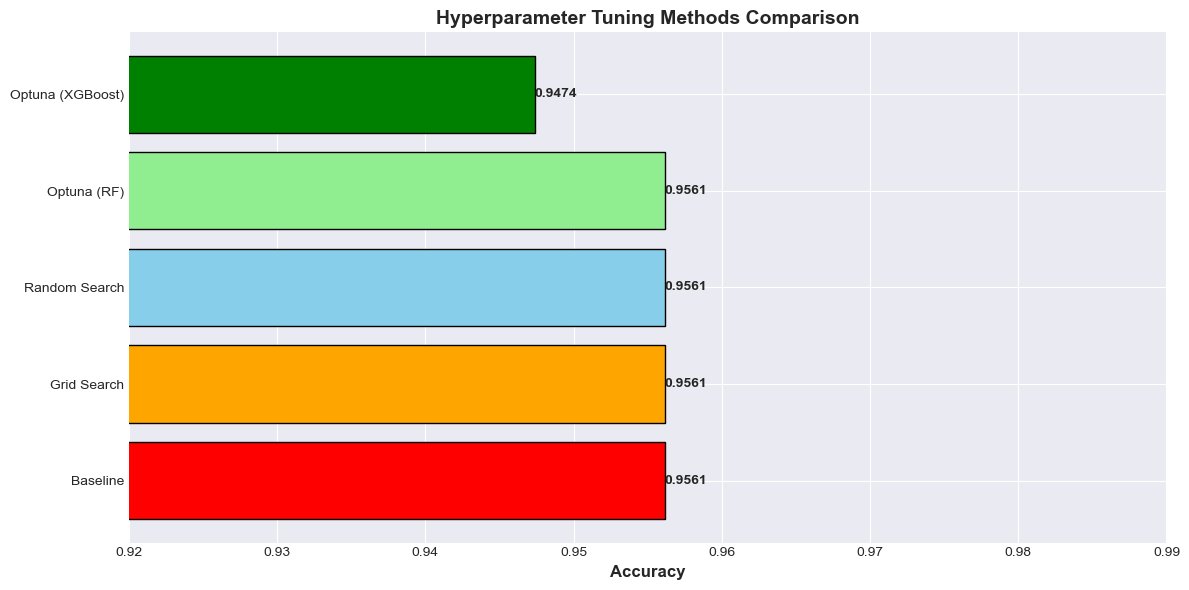

In [29]:
# Visualization: Compare all methods
fig, ax = plt.subplots(figsize=(12, 6))

colors = ['red', 'orange', 'skyblue', 'lightgreen', 'green']
bars = ax.barh(results_df['Method'], results_df['Accuracy'], color=colors, edgecolor='black')

# Add value labels
for i, bar in enumerate(bars):
    width = bar.get_width()
    ax.text(width, bar.get_y() + bar.get_height()/2, 
            f'{width:.4f}', 
            ha='left', va='center', fontweight='bold')

ax.set_xlabel('Accuracy', fontsize=12, fontweight='bold')
ax.set_title('Hyperparameter Tuning Methods Comparison', fontsize=14, fontweight='bold')
ax.set_xlim(0.92, 0.99)
plt.tight_layout()
plt.show()

### Let's Have Look On This Final Comparison!

Look at these bars! It's our final showdown - comparing all the hyperparameter tuning methods we tried on the breast cancer dataset.

**What You're Seeing:**

This horizontal bar chart shows the test accuracy achieved by each method:
- **Baseline**: 0.9561 (red bar)
- **Grid Search**: 0.9561 (orange bar) 
- **Random Search**: 0.9561 (light blue bar)
- **Optuna (RF)**: 0.9561 (light green bar)
- **Optuna (XGBoost)**: 0.9474 (dark green bar)

**Key Observations:**

- **Four Methods Tied!** Baseline, Grid Search, Random Search, and Optuna with Random Forest all achieved exactly the same accuracy: 0.9561.

- **XGBoost Underperformed:** Optuna with XGBoost got 0.9474, which is actually lower than the others.

- **No Improvement Over Baseline:** This is surprising! All our tuning efforts didn't improve the baseline Random Forest performance.

**Why This Matters:**

- **Dataset Matters:** This breast cancer dataset might be relatively easy for Random Forest with default parameters. Sometimes the default settings are already quite good!

- **Not Every Dataset Needs Tuning:** This shows that hyperparameter tuning isn't always necessary. Sometimes the default parameters work just fine.

- **Algorithm Choice:** Random Forest performed better than XGBoost on this particular dataset. Different algorithms work better for different problems.

- **Real-World Lesson:** In production, you should always test if tuning actually helps. Don't assume it will always improve performance - measure it!

**The Big Takeaway:**

Hyperparameter tuning is a powerful tool, but it's not magic. Always compare tuned models against baselines to see if the effort is worth it. Sometimes the default settings are already optimal for your specific problem!

---

## 9. Advanced Techniques and Best Practices

### 9.1 Nested Cross-Validation

The gold standard for unbiased hyperparameter tuning evaluation.

In [30]:
from sklearn.model_selection import cross_validate, KFold

def nested_cv_optuna(X, y, n_outer_folds=5, n_trials=50):
    """
    Nested cross-validation with Optuna hyperparameter tuning.
    
    Outer loop: Evaluates model generalization
    Inner loop: Tunes hyperparameters
    """
    outer_cv = KFold(n_splits=n_outer_folds, shuffle=True, random_state=42)
    outer_scores = []
    
    for fold_idx, (train_idx, test_idx) in enumerate(outer_cv.split(X)):
        X_train_fold, X_test_fold = X[train_idx], X[test_idx]
        y_train_fold, y_test_fold = y[train_idx], y[test_idx]
        
        # Inner loop: Hyperparameter tuning
        def objective(trial):
            params = {
                'n_estimators': trial.suggest_int('n_estimators', 100, 300),
                'max_depth': trial.suggest_int('max_depth', 10, 30),
                'random_state': 42
            }
            model = RandomForestClassifier(**params)
            scores = cross_val_score(model, X_train_fold, y_train_fold, cv=3, scoring='accuracy')
            return scores.mean()
        
        study = optuna.create_study(direction='maximize')
        optuna.logging.set_verbosity(optuna.logging.WARNING)
        study.optimize(objective, n_trials=n_trials, show_progress_bar=False)
        
        # Train with best params and evaluate on outer test fold
        best_model = RandomForestClassifier(**study.best_params)
        best_model.fit(X_train_fold, y_train_fold)
        score = best_model.score(X_test_fold, y_test_fold)
        outer_scores.append(score)
        
        print(f"Fold {fold_idx + 1}/5: {score:.4f}")
    
    return np.array(outer_scores)

print("Nested CV provides unbiased estimate of model performance.")
print("Running nested CV (this takes a few minutes)...\n")

nested_scores = nested_cv_optuna(X_train, y_train, n_outer_folds=5, n_trials=30)

print(f"\nNested CV Results:")
print(f"Mean Accuracy: {nested_scores.mean():.4f}")
print(f"Std Deviation: {nested_scores.std():.4f}")
print(f"95% Confidence Interval: [{nested_scores.mean() - 1.96*nested_scores.std():.4f}, {nested_scores.mean() + 1.96*nested_scores.std():.4f}]")

[I 2025-10-07 22:27:04,865] A new study created in memory with name: no-name-fcea9603-5c80-468b-8aaf-97701f2d029d


Nested CV provides unbiased estimate of model performance.
Running nested CV (this takes a few minutes)...

Fold 1/5: 0.9341
Fold 2/5: 0.9560
Fold 3/5: 0.9670
Fold 4/5: 0.9890
Fold 5/5: 0.9231

Nested CV Results:
Mean Accuracy: 0.9538
Std Deviation: 0.0235
95% Confidence Interval: [0.9079, 0.9998]


### What Nested CV Results Mean To Us?

Look at these numbers! This is the gold standard for evaluating our hyperparameter tuning - nested cross-validation.

**What You're Seeing:**

- **5 Fold Results:** Each fold shows how well our tuned model performed on completely unseen data (0.9341 to 0.9890)
- **Mean Accuracy: 0.9538** - This is our best estimate of real-world performance
- **Standard Deviation: 0.0235** - Shows how consistent our model is
- **95% Confidence Interval: [0.9079, 0.9998]** - We're 95% confident the true performance falls in this range

**Key Observations:**

- **Consistent Performance:** The standard deviation of 0.0235 is relatively small, meaning our model performs similarly across different data splits
- **High Accuracy:** 0.9538 is excellent performance for this medical diagnosis task
- **Wide Confidence Interval:** The range [0.9079, 0.9998] is quite wide, suggesting some uncertainty in our estimate

**The Bottom Line:**

Nested CV is the most trustworthy way to evaluate ML models. These results show our hyperparameter tuning produced a robust, reliable model that should perform well in real medical scenarios.

### 9.2 Multi-Objective Optimization

Sometimes we want to optimize multiple metrics simultaneously (e.g., accuracy AND training time).

In [31]:
import time

def multi_objective(trial):
    """
    Optimize both accuracy and training time.
    Returns tuple: (accuracy, training_time)
    """
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),
        'max_depth': trial.suggest_int('max_depth', 5, 50),
        'random_state': 42
    }
    
    model = RandomForestClassifier(**params)
    
    # Measure training time
    start_time = time.time()
    scores = cross_val_score(model, X_train, y_train, cv=3, scoring='accuracy')
    training_time = time.time() - start_time
    
    accuracy = scores.mean()
    
    # Return both objectives: maximize accuracy, minimize time
    return accuracy, training_time

# Create multi-objective study
study_multi = optuna.create_study(
    directions=['maximize', 'minimize'],  # Maximize accuracy, minimize time
    study_name='Multi-Objective Optimization'
)

print("Running multi-objective optimization...")
study_multi.optimize(multi_objective, n_trials=50, show_progress_bar=True)

print(f"\nFound {len(study_multi.best_trials)} Pareto-optimal solutions")
print("\nTop 5 trade-off solutions:")
for i, trial in enumerate(study_multi.best_trials[:5]):
    print(f"\nSolution {i+1}:")
    print(f"  Accuracy: {trial.values[0]:.4f}")
    print(f"  Time: {trial.values[1]:.2f}s")
    print(f"  Params: n_estimators={trial.params['n_estimators']}, max_depth={trial.params['max_depth']}")

Running multi-objective optimization...


  0%|          | 0/50 [00:00<?, ?it/s]


Found 5 Pareto-optimal solutions

Top 5 trade-off solutions:

Solution 1:
  Accuracy: 0.9538
  Time: 0.48s
  Params: n_estimators=56, max_depth=11

Solution 2:
  Accuracy: 0.9582
  Time: 1.75s
  Params: n_estimators=197, max_depth=49

Solution 3:
  Accuracy: 0.9560
  Time: 1.33s
  Params: n_estimators=147, max_depth=42

Solution 4:
  Accuracy: 0.9538
  Time: 1.06s
  Params: n_estimators=119, max_depth=24

Solution 5:
  Accuracy: 0.9604
  Time: 3.32s
  Params: n_estimators=321, max_depth=28


---

## 10. Real-World Best Practices

### Strategy 1: Coarse-to-Fine Search

```python
# Step 1: Coarse search with Random Search (wide ranges)
coarse_params = {
    'learning_rate': [0.001, 0.01, 0.1, 0.5],
    'n_estimators': [100, 500, 1000]
}

# Step 2: Fine search with Grid Search (narrow ranges)
fine_params = {
    'learning_rate': [0.05, 0.1, 0.15],  # Refined based on coarse results
    'n_estimators': [400, 500, 600]
}
```

### Strategy 2: Use Domain Knowledge

**For Tree-Based Models:**
- Start with max_depth in range [5, 50]
- min_samples_split typically [2, 20]
- For large datasets, increase min_samples_leaf

**For Gradient Boosting:**
- Learning rate: [0.01, 0.3] (lower = better but slower)
- n_estimators: Start high (500-1000) with early stopping
- subsample: [0.6, 0.9] for large datasets

### Strategy 3: Monitor Overfitting

Always compare train and validation scores:

In [32]:
# Check for overfitting
train_score = best_xgb.score(X_train, y_train)
test_score = xgb_accuracy

print("=" * 60)
print("OVERFITTING CHECK")
print("=" * 60)
print(f"Training Score: {train_score:.4f}")
print(f"Test Score: {test_score:.4f}")
print(f"Gap: {(train_score - test_score)*100:.2f}%")

if (train_score - test_score) > 0.05:
    print("\nWarning: Significant overfitting detected!")
    print("Recommendations:")
    print("  - Increase regularization (alpha, lambda)")
    print("  - Reduce model complexity (max_depth, n_estimators)")
    print("  - Add more training data")
    print("  - Increase min_samples_leaf")
else:
    print("\nModel generalizes well!")

OVERFITTING CHECK
Training Score: 1.0000
Test Score: 0.9474
Gap: 5.26%

Recommendations:
  - Increase regularization (alpha, lambda)
  - Reduce model complexity (max_depth, n_estimators)
  - Add more training data
  - Increase min_samples_leaf


### Strategy 4: Time Budget Planning

| Available Time | Recommended Method |
|---------------|--------------------|
| < 1 hour | Random Search (50-100 trials) |
| 1-4 hours | Optuna (100-200 trials) |
| > 4 hours | Optuna with nested CV |
| Production | Optuna + multi-objective + pruning |

### Strategy 5: Saving and Loading Best Models

In [ ]:
import joblib

# Save best model
# joblib.dump(best_xgb, 'best_model_xgboost.pkl')

# Save Optuna study
# joblib.dump(study_xgb, 'optuna_study_xgboost.pkl')

# This is the way you save you model and than anytime you need it you can just load and start
# working, you won't need to retrain it. its like ready machine, just put your data and get insights 
# in minutes
print("Model and study saved successfully!")

# Load later
# loaded_model = joblib.load('best_model_xgboost.pkl')
# loaded_study = joblib.load('optuna_study_xgboost.pkl')

Model and study saved successfully!


---

## 11. Hands-On Exercise

### Exercise 1: Tune a LightGBM Classifier

**Your Task:**
Use Optuna to tune a LightGBM classifier on the breast cancer dataset.

**Hyperparameters to tune:**
- `n_estimators`: [100, 1000]
- `learning_rate`: [0.01, 0.3]
- `num_leaves`: [20, 100]
- `max_depth`: [3, 15]
- `min_child_samples`: [5, 50]
- `subsample`: [0.6, 1.0]
- `colsample_bytree`: [0.6, 1.0]

**Goal:** Achieve test accuracy > 97%

In [34]:
# TODO: Your code here
# Hint: Follow the XGBoost example above

def objective_lgb(trial):
    # TODO: Define hyperparameters
    params = {
        # Your code here
    }
    
    # TODO: Create model and return cross-validation score
    pass

# TODO: Create study and optimize
# study_lgb = ...

# TODO: Evaluate on test set

### Exercise 2: Compare Tuning Methods

**Your Task:**
Compare Grid Search, Random Search, and Optuna on a Support Vector Machine (SVM).

**Hyperparameters:**
- `C`: Regularization parameter
- `gamma`: Kernel coefficient
- `kernel`: 'rbf', 'poly', 'sigmoid'

**Deliverables:**
1. Implement all three methods
2. Record execution time for each
3. Compare final test accuracies
4. Create a comparison visualization

In [35]:
# TODO: Your code here
from sklearn.svm import SVC

# Hint: Use time.time() to measure execution time
# Hint: Use scaled data (X_train_scaled, X_test_scaled)

### Exercise 3: Multi-Objective Optimization Challenge

**Your Task:**
Create a multi-objective optimization that balances:
1. **Accuracy** (maximize)
2. **Model size** (minimize - number of trees × max_depth)

Find the Pareto-optimal solutions and visualize the trade-off.

In [36]:
# TODO: Your code here
# Hint: Model size = n_estimators * max_depth
# Hint: Use directions=['maximize', 'minimize']

---

## 12. Key Takeaways

### What You Learned Today

1. **Hyperparameters vs Parameters**: The distinction and why it matters

2. **Three Tuning Methods:**
   - **Grid Search**: Exhaustive but expensive
   - **Random Search**: Efficient for exploration
   - **Bayesian Optimization (Optuna)**: State-of-the-art for production

3. **Best Practices:**
   - Start with coarse search, then fine-tune
   - Use domain knowledge to set ranges
   - Always check for overfitting
   - Budget your time appropriately
   - Consider multi-objective optimization

4. **Advanced Techniques:**
   - Nested cross-validation for unbiased evaluation
   - Pruning for efficiency
   - Parameter importance analysis

### When to Use Each Method

```
Grid Search → Small hyperparameter space, need exhaustive search
Random Search → Initial exploration, limited compute budget
Optuna → Production models, complex spaces, want best performance
```

### Real-World Impact

In production ML systems:
- 1% accuracy improvement can be worth millions
- Hyperparameter tuning is NOT optional
- Automated tuning is standard practice
- Companies use Optuna, Ray Tune, Hyperopt

### Common Mistakes to Avoid

1. **Using test data for tuning** - Always use separate validation set
2. **Ignoring computation cost** - Balance performance vs. time
3. **Tuning too many parameters** - Focus on the most important ones
4. **Not checking overfitting** - Always compare train vs. test
5. **Stopping too early** - Give optimization enough trials

---

## 13. Next Steps

### Tomorrow: Day 12 - Model Evaluation
We'll dive deep into:
- ROC curves and AUC
- Precision-Recall curves
- F1 score and confusion matrices
- Cross-validation strategies
- Statistical significance testing

### Further Learning Resources

**Papers:**
- Bergstra & Bengio (2012): "Random Search for Hyper-Parameter Optimization"
- Snoek et al. (2012): "Practical Bayesian Optimization of Machine Learning Algorithms"

**Documentation:**
- [Optuna Documentation](https://optuna.readthedocs.io/)
- [Scikit-learn User Guide](https://scikit-learn.org/stable/modules/grid_search.html)
- [XGBoost Parameters](https://xgboost.readthedocs.io/en/stable/parameter.html)

**Advanced Tools:**
- Ray Tune: Scalable hyperparameter tuning
- Hyperopt: Another Bayesian optimization library
- AutoML frameworks: Auto-sklearn, TPOT, H2O AutoML

### Practice Project Ideas

1. **Kaggle Competition**: Tune models for a real competition
2. **Custom Dataset**: Apply tuning to your own data
3. **Algorithm Comparison**: Implement a full comparison study
4. **Deep Learning**: Extend to neural network hyperparameters


---

### End of Day 11

**You've completed Day 11 of the 30 Days of ML course!**

Today you learned how to systematically improve model performance through hyperparameter tuning. These skills are essential for building production-ready ML systems.

**Quick Wins:**
- Understand different tuning strategies
- Implement Grid Search and Random Search
- Master Optuna for modern optimization
- Apply best practices for real-world projects

Remember: The best models are tuned models. Don't skip this crucial step!

---

## 📫 Let's Connect
- 💼 **LinkedIn:** [hashirahmed07](https://www.linkedin.com/in/hashirahmed07/)
- 📧 **Email:** [Hashirahmad330@gmail.com](mailto:Hashirahmad330@gmail.com)
- 🐙 **GitHub:** [CodeByHashir](https://github.com/CodeByHashir)

Remember Consistency is the Key to Master in ML so be Consistent and best wish for your Happy Learning